In [1]:
import numpy as np
import ceo
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
# entrance pupil sampling
n_px = 512
L = 25.5

In [3]:
gmt = ceo.GMT_MX()
src = ceo.Source('V',rays_box_size=L,rays_box_sampling=n_px)
src>>(gmt,)
+src
pssn0 ,pssn_data = gmt.PSSn(src,save=True)

In [4]:
# "ideal" GMT WFE RMS [nm] & PSSn
src.wavefront.rms(-9),pssn0

(array([0.76414394], dtype=float32), array([1.]))

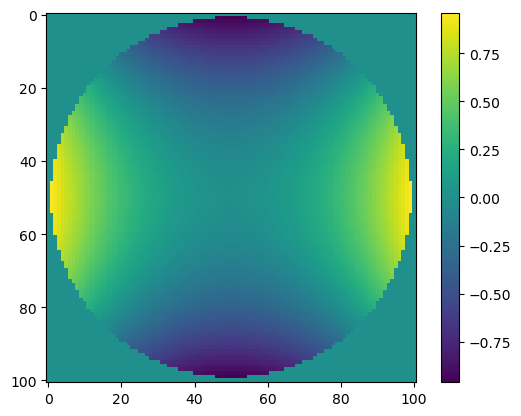

In [5]:
# an astigmatism on a single segment
segment_n_px = 101
segment_L = 8.5
segment_clear_aperture = 8.365
u = np.linspace(-1,1,segment_n_px)
x,y = np.meshgrid(u,u)
r = np.hypot(x,y)
o = np.arctan2(y,x)
phase_map = r**2*np.cos(2*o)

fig, ax = plt.subplots()
h = ax.imshow(phase_map*(r<(segment_clear_aperture/segment_L)))
fig.colorbar(h,ax=ax)

In [6]:
from scipy.ndimage import rotate

phase_map7 = np.zeros((segment_n_px, segment_n_px, 7))
rotation_angles = [-i*30 for i in range(7)]
for i, angle in enumerate(rotation_angles):
    phase_map7[:,:,i] = rotate(phase_map, angle, reshape=False)

In [7]:
rotation_angles

[0, -30, -60, -90, -120, -150, -180]

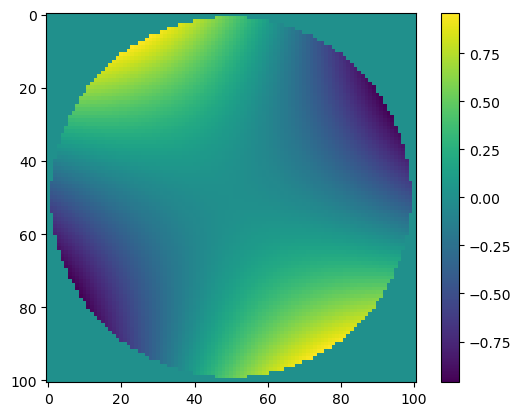

In [8]:
fig, ax = plt.subplots()
h = ax.imshow(phase_map7[:,:,2]*(r<(segment_clear_aperture/segment_L)))
fig.colorbar(h,ax=ax)

In [9]:
# writing the astigmatism to the "CEO" file format
import os 
from collections import OrderedDict

data = OrderedDict()
data['Ni']     = np.array( segment_n_px, dtype=np.int32)
data['L']      = np.array( segment_L,    dtype=np.double)
data['N_SET']  = np.array( 7,     dtype=np.int32)
data['N_MODE'] = np.array( 1,     dtype=np.int32)
data['s2b']    = np.array( [0,1,2,3,4,5,6], dtype=np.int32) #which segment uses which basis set
data['M'] = phase_map7.flatten(order='F')

path_to_ceo = "/home/ubuntu/CEO/" # CHANGE THIS TO THE CEO PATH ON YOUR MACHINE
filename = "made-up_mode"
path_to_modes = os.path.join( path_to_ceo , 'gmtMirrors' , filename+'.ceo' )
with open(path_to_modes,'w') as f:
    for key in data:
        data[key].tofile(f)

In [10]:
# loading the new mode and setting it up on all M1 segments with 1e-7m amplitude
gmt = ceo.GMT_MX(M1_mirror_modes="made-up_mode",M1_N_MODE=1)
src = ceo.Source('V',rays_box_size=L,rays_box_sampling=n_px)
state = gmt.state
state["M1"]["modes"][:,0] = 1e-7
gmt^=state
src>>(gmt,)
+src

In [11]:
state["M1"]["modes"].shape

(7, 1)

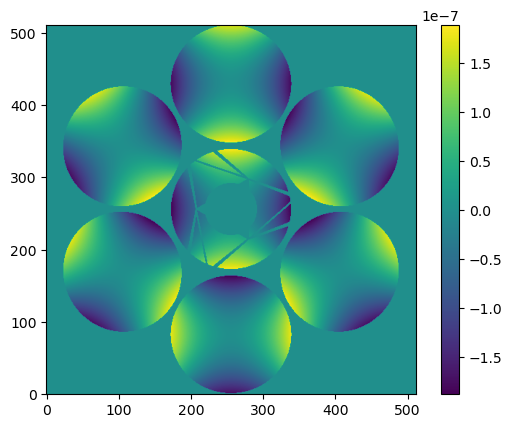

In [12]:
fig, ax = plt.subplots()
h = ax.imshow(src.phase.host(), origin='lower')
fig.colorbar(h,ax=ax)

In [13]:
# "aberrated" GMT WFE RMS [nm] & PSSn
src.wavefront.rms(-9),gmt.PSSn(src,**pssn_data)

(array([75.372154], dtype=float32), array([0.99868182]))